# RSI model-05 ( Regression approach )
https://chatgpt.com/c/67ff8405-7cfc-800a-b166-c9137db53451

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Hyperparameters (modifiable)
rsi_period = 14
buy_zone = 30
sell_zone = 70
input_window = 30
future_window = 100


In [28]:
# Load training data (10 years of historical data)
df = pd.read_csv("XAGUSD-H1-rates.csv", sep="\t")

# Keep relevant columns only

df.columns = df.columns.str.strip()  # Clean headers
df = df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>']]

# Calculate RSI
df['<RSI>'] = RSIIndicator(close=df['<CLOSE>'], window=rsi_period).rsi()
df = df.dropna().reset_index(drop=True)


In [29]:
def get_reversal_signals(rsi_series):
    signals = []
    for rsi in rsi_series:
        if rsi < buy_zone:
            signals.append(1)  # Buy signal
        elif rsi > sell_zone:
            signals.append(2)  # Sell signal
        else:
            signals.append(0)  # No signal
    return signals


In [30]:
X, y = [], []

max_samples = 10000  # Limit to avoid RAM crash, adjust this safely

for i in range(min(len(df) - input_window - future_window, max_samples)):
    window = df.iloc[i:i+input_window]
    future = df.iloc[i+input_window:i+input_window+future_window]

    x_chunk = window[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<RSI>']].values
    y_chunk = future['<CLOSE>'].values

    if len(x_chunk) == input_window and len(y_chunk) == future_window:
        X.append(x_chunk)
        y.append(y_chunk)


In [31]:
X = np.array(X)
y = np.array(y)

In [32]:

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=False, input_shape=(input_window, X.shape[2])),
    Dense(future_window)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


/home/saeed/repositories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,420 (95.39 KB)

 Trainable params: 24,420 (95.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 128.4001 - val_loss: 0.4961
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4298 - val_loss: 0.2746
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2736 - val_loss: 0.2186
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2090 - val_loss: 0.2021
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2024 - val_loss: 0.2033
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1920 - val_loss: 0.1706
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1739 - val_loss: 0.1641
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1774 - val_loss: 0.1591
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1659 - val_loss: 0.1849
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1645 - val_loss: 0.1680


In [36]:
# Load 30 most recent candles
recent_df = pd.read_csv("new-data-for-test/rows-30-from-20240503.csv", sep="\t")
recent_df = recent_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>']]
recent_df['<RSI>'] = RSIIndicator(close=recent_df['<CLOSE>'], window=rsi_period).rsi()
recent_df = recent_df.dropna().reset_index(drop=True)

# Prepare input
X_input = recent_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<RSI>']].values[-input_window:]
X_input = np.expand_dims(X_input, axis=0)


In [37]:
# Predict next 100 future CLOSE prices
predicted_close = model.predict(X_input)[0]

# Combine real + predicted close prices for full RSI chart
full_close = np.concatenate([recent_df['<CLOSE>'].values[-input_window:], predicted_close])

# Compute RSI on full series
rsi_series = RSIIndicator(close=pd.Series(full_close), window=rsi_period).rsi().fillna(0)
reversal_signals = get_reversal_signals(rsi_series)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


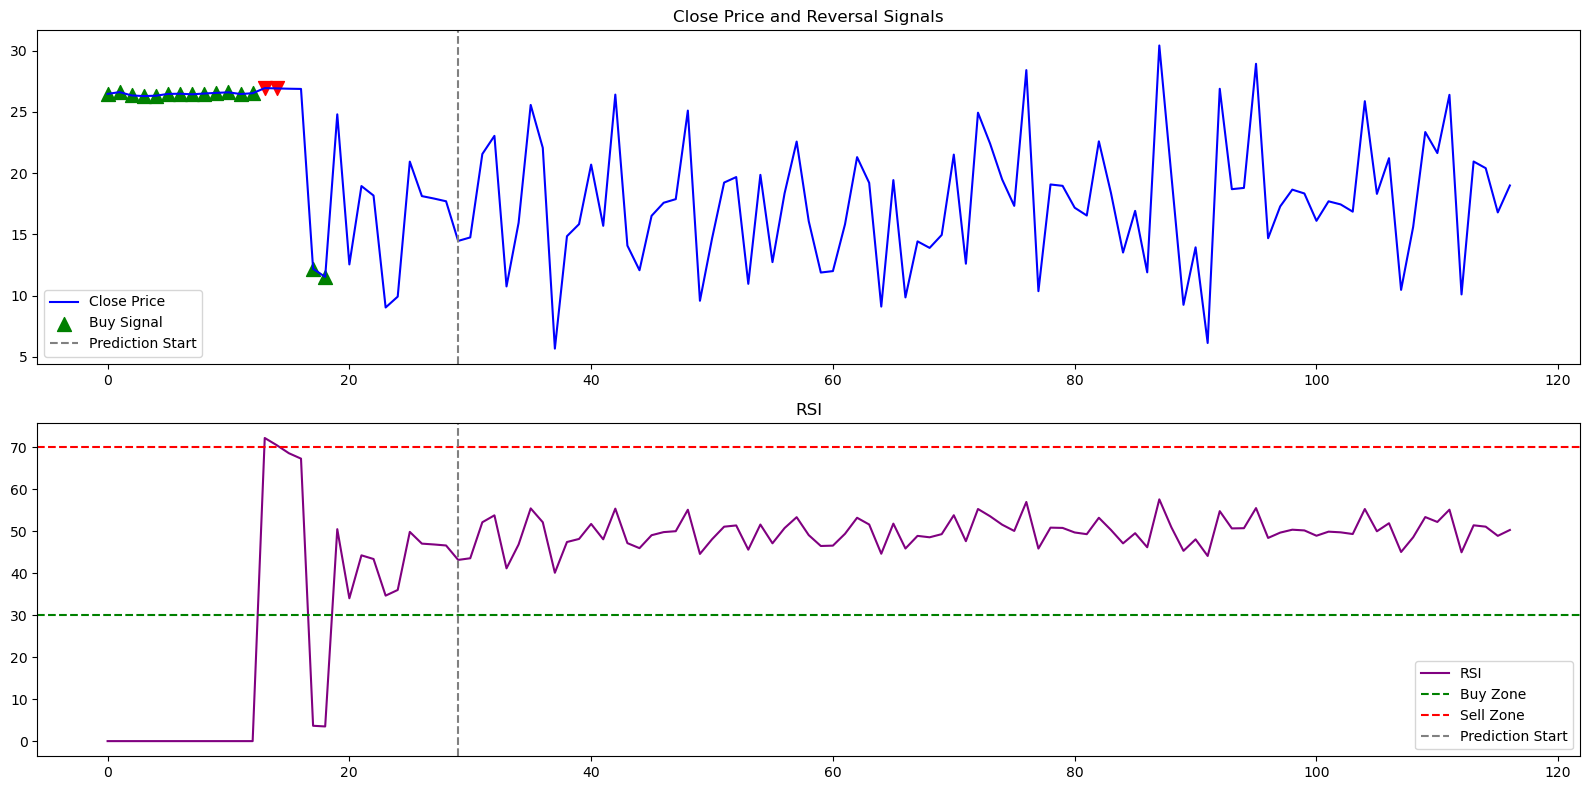

In [38]:
plt.figure(figsize=(16, 8))

# Price chart
plt.subplot(2, 1, 1)
plt.plot(full_close, label='Close Price', color='blue')
for i, sig in enumerate(reversal_signals):
    if sig == 1:
        plt.scatter(i, full_close[i], color='green', label='Buy Signal' if i == 0 else "", marker='^', s=100)
    elif sig == 2:
        plt.scatter(i, full_close[i], color='red', label='Sell Signal' if i == 0 else "", marker='v', s=100)
plt.axvline(x=input_window-1, color='gray', linestyle='--', label='Prediction Start')
plt.title('Close Price and Reversal Signals')
plt.legend()

# RSI chart
plt.subplot(2, 1, 2)
plt.plot(rsi_series, label='RSI', color='purple')
plt.axhline(buy_zone, color='green', linestyle='--', label='Buy Zone')
plt.axhline(sell_zone, color='red', linestyle='--', label='Sell Zone')
plt.axvline(x=input_window-1, color='gray', linestyle='--', label='Prediction Start')
plt.title('RSI')
plt.legend()

plt.tight_layout()
plt.show()
